In [1]:
from pathlib import Path

import pandas as pd
from pandas.errors import EmptyDataError 

import matplotlib.pyplot as plt

from datetime import datetime as dt
from datetime import time, timedelta

In [2]:
# This method takes in paramaters:
# 1) recover_folder: Name of the folder where the detections are stored.
# 2) audio_dur: The AudioMoth's configuration for the length of each recording.

# This method returns:
# - A DataFrame object that has columns:
#   - File Names, Date, Start Time, End Time, # of LF detections, # of HF detections
#   - File Names are strings and # of LF/HF detections are integers.
#   - Times are in UTC format and Dates are datetime.datetime objects.

def generate_df(recover_folder, audio_dur=pd.DateOffset(minutes=29, seconds=55)):

    # detection_dir is the recover-DATE-UNIT_NUM-detect folder where our detections are.
    detection_dir = f"detections/{recover_folder}"

    # Construct path object linked to the directory of files for datetime-parsing
    file_dir = Path(detection_dir)
    # We use this to only extract the original file names of the recordings.
    # The detection files will be assembled below.
    sorted_files = sorted(file_dir.glob('hf_*.txt'))

    # Create empty DataFrame object with all the required columns    
    df = pd.DataFrame(columns=["File Names", "Date", "Start Time (UTC)",
                       "End Time (UTC)", "# of LF detections", "# of HF detections"])
    
    # Iterate through all file paths to extract and store table information for each file
    for i, file in enumerate(sorted_files):
        # Extract name of each file as it is
        file_name = file.name
        # Extracting the datetime object from the name of each file
        file_info = dt.strptime(file_name, "hf_%Y%m%d_%H%M%S.WAV.txt")

        # Extract recording name, date, start time, and end time for each file
        recording_name = file_info.strftime("%Y%m%d_%H%M%S.WAV")
        date = file_info.date()
        s_time = file_info.time()
        e_time = (file_info+audio_dur).time()

        # Calling read_detection to return the table of selections as a dataframe
        # The detections appear twice: in waveform view and spectrogram view, 
        # so we half the total number of detections
        lf_file_detections = read_detection(detection_dir, recording_name, "lf")
        num_lf_detections = lf_file_detections.shape[0]/2
        hf_file_detections = read_detection(detection_dir, recording_name, 'hf')
        num_hf_detections = hf_file_detections.shape[0]/2
        
        # Add new row with the extracted information
        df.loc[len(df.index)] = [recording_name, date, s_time, e_time, num_lf_detections, num_hf_detections]
    
    return df

In [3]:
# Given parameters:
# 1) detection_dir is the recover-DATE-UNIT_NUM-detect folder
# 2) recording_name is the name of our recording: DATE_TIME.WAV
# 4) det_type can either be 'lf' or 'hf'

# Output:
# The table of detections following the format of RavenPro

def read_detection(detection_dir, recording_name, det_type):
    
    file_name = f"{det_type}_{recording_name}.txt"
    file_path = f"{detection_dir}/{file_name}"
    
    if (Path(file_path).is_file()):
        try:
            df_detection = pd.read_csv(file_path, sep='\t')
        except EmptyDataError:
            print(f"{file_path} is empty")
            
    return df_detection

In [17]:
def plot_separate(df, save=True):
    
    # To plot each day's activity separately, group by rows that have the same date
    # We need a list of unique dates from our detection files
    unique_dates = df["Date"].unique()

    # Here we also construct a time vector to make each plot comparable
    s_times = []
    i=0
    s_times.append(time(0, 0, 0))
    while (s_times[i] != time(hour=23, minute=30, second=0)):
        old_dt = (dt.combine(unique_dates[0], s_times[i]))
        new_dt = old_dt+pd.DateOffset(minutes=30)
        s_times.append(new_dt.time())
        i+=1
    
    # We plot for each date in our unique dates
    for date in unique_dates:
        day_df = df.loc[df['Date'] == date]
        
        fig = day_df.plot.bar(x="Start Time (UTC)", figsize=(12, 4), fontsize=12, rot=60)
        fig.set_title(date, fontsize=14)
        # Here we set the time vector we constructed
        fig.set_xticks(range(len(s_times)), s_times)      
        
        # If the user wants to save, it goes into the below path
        if save:
            save_folder = f"../results/raven_energy_detector_raw/call_num_summary/{recover_folder}/FIGS"
            save_dir = Path(save_folder)
            save_dir.mkdir(parents=True, exist_ok=True)
            save_path = Path(f"{save_folder}/{date}.png")
            fig.get_figure().savefig(save_path, facecolor='w')
          

In [30]:
def plot_total(df):
    
    # To plot each day's activity separately, group by rows that have the same date
    # We need a list of unique dates from our detection files
    unique_dates = df["Date"].unique()
    
    fig = df.plot.bar(x="Start Time (UTC)", figsize=(12, 4), fontsize=12, rot=60)
    fig.set_title(f"Total Deployment Session from {unique_dates[0]} to {unique_dates[-1]}", fontsize=14)
    fig.set_xticks(fig.get_xticks()[::len(unique_dates)])

In [31]:
# These are constants that we absolutely need to know before running any scripts

# Constant DATE is the date of our recovered data that we are extracting detections from
DATE = "20220728"
# Constant SD_CARD_NUM is the SD CARD # that had been deployed for that session
SD_CARD_NUM = "008"

In [32]:
recover_folder = f"recover-{DATE}-{SD_CARD_NUM}-detect"
df = generate_df(recover_folder)

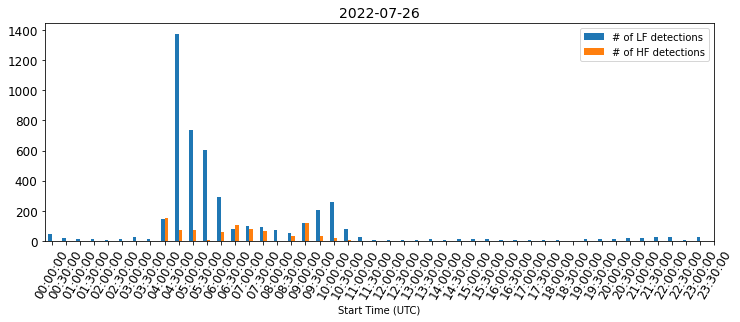

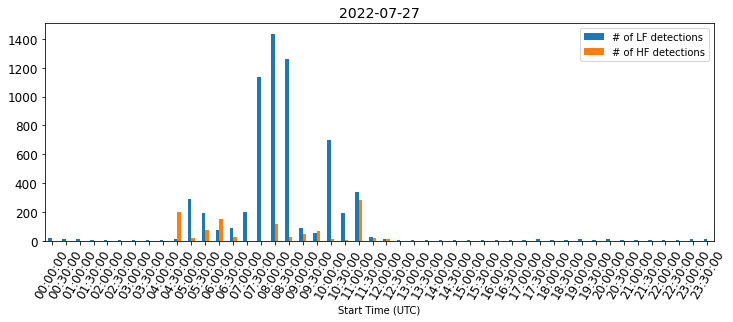

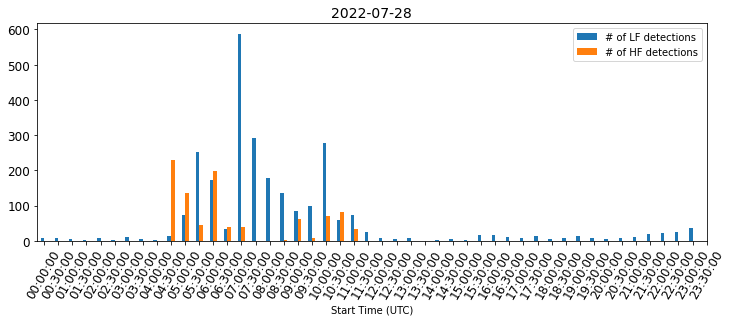

In [33]:
plot_separate(df)

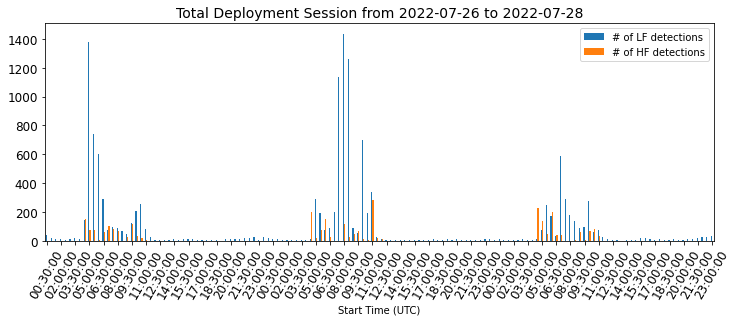

In [34]:
plot_total(df)

In [35]:
df_all = pd.concat([df, generate_df(f"recover-20220801-005-detect")])

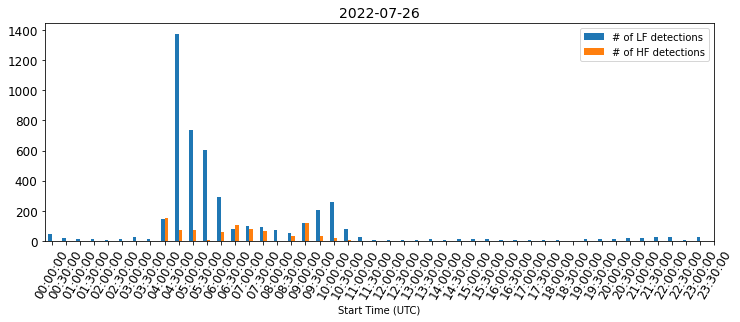

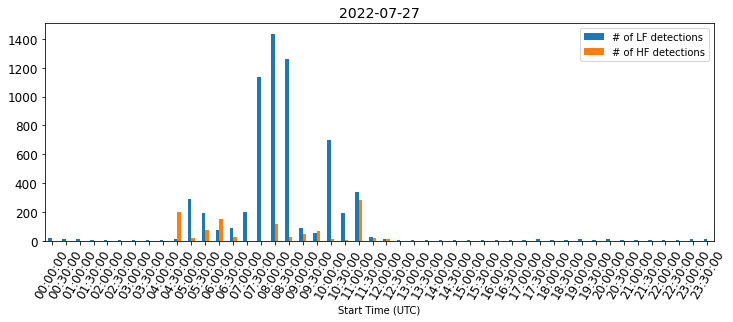

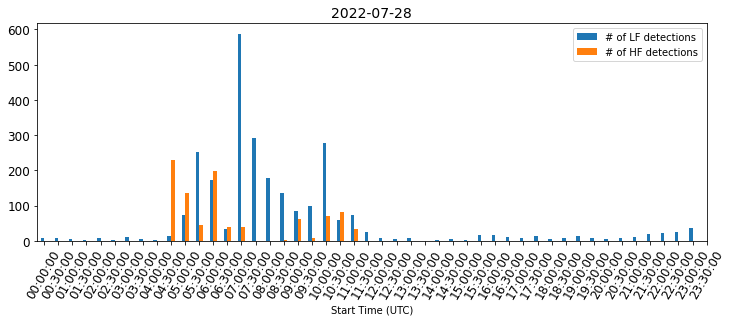

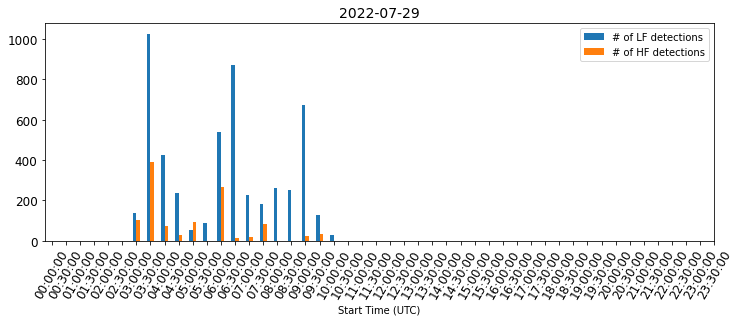

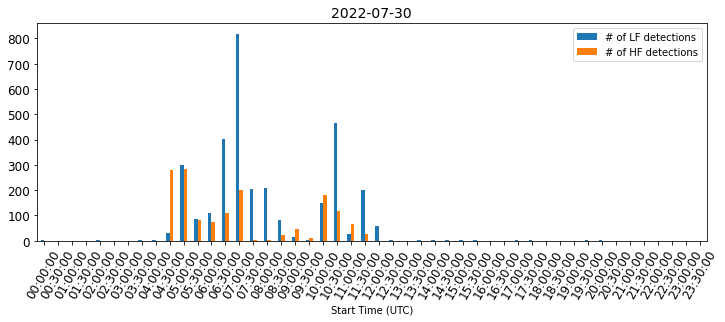

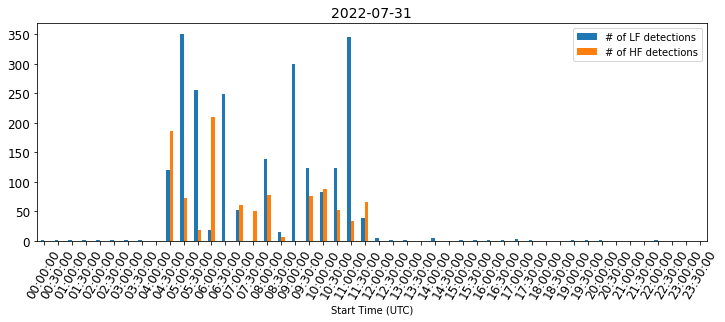

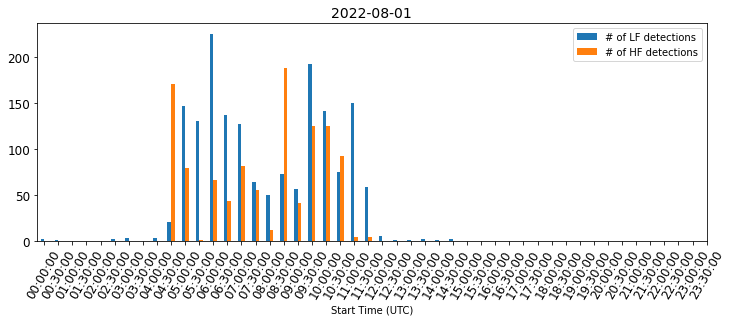

In [36]:
plot_separate(df_all)

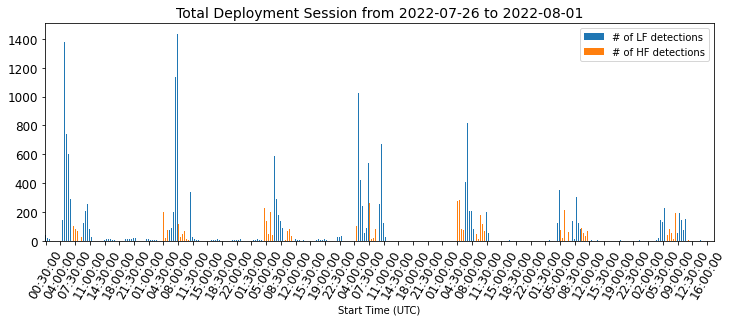

In [37]:
plot_total(df_all)